In [ ]:
# 참고
https://www.kaggle.com/devdgohil/intel-image-classification

In [1]:
# tensorflow 버전 확인
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# 내 구글 드라이버에 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 1.먼저 본인의 Kaggle 계정에서 API Token 을 다운받습니다.(kaggle.json)
# 2.Kaggle API를 설치합니다.
!pip install kaggle   
# 3.kaggle.json 파일을 VM에 업로드 합니다.
from google.colab import files
files.upload()

In [4]:
# 4.파일이 재대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [5]:
# 5.Kaggle API 가 Token을 사용하게 하기 위해 kaggle.json 파일을 ~/.kaggle로 이동 시킵니다.
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
# 6. Permission Warning 이 일어나지 않도록 권한 부여
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# dataset URL : https://www.kaggle.com/puneet6060/intel-image-classification
# 7.Kaggle 에서 intel-image-classification dataset을 다운 받기 위해 API Command 를 복사해서 가져옵니다.
!kaggle datasets download -d puneet6060/intel-image-classification

 98% 340M/346M [00:02<00:00, 156MB/s]
100% 346M/346M [00:02<00:00, 147MB/s]


In [7]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('intel-image-classification.zip') as z: 
    z.extractall()

In [8]:
# 필요한 패키지와 모듈을 불러옴
import math
import os
import cv2
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model, layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2

In [9]:
# ImageDataGenerator 클래스를 통해 train_datagen 인스턴스를 만듭니다.
train_datagen = ImageDataGenerator( 
    zoom_range=0.2,        # 20%까지 확대
    rotation_range=10,     # 10도까지 회전
    horizontal_flip=True,  # 좌우 뒤집기  
    rescale=1./255)        # 픽셀 값을 0~1 범위로 변환

# train_datagen 인스턴스를 통해 trin dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 train_generator 객체를 생성한다
train_generator = train_datagen.flow_from_directory(
    '/content/seg_train/seg_train',
    batch_size=100,      # Size of the batches of data (default: 32).
    class_mode='sparse', # Determines the type of label arrays that are returned. "sparse" will be 1D integer labels
    target_size=(150, 150))  # 이미지의 크기 재정의
 
# ImageDataGenerator 클래스를 통해 test_datagen 인스턴스를 만듭니다.
test_datagen = ImageDataGenerator(
    zoom_range=0.2,        # 20%까지 확대
    rotation_range=10,     # 10도까지 회전
    horizontal_flip=True,  # 좌우 뒤집기  
    rescale=1./255)        # 픽셀 값을 0~1 범위로 변환

# ImageDataGenerator를 통해 validation dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_generator 객체를 생성한다.
test_generator = test_datagen.flow_from_directory(
    '/content/seg_test/seg_test',
    batch_size=100,
    class_mode='sparse',
    target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
# label name 을 찾아 오는 함수를 정의한다.
def findKey(indices, search_value):
    for key, value in indices.items():
        if(value == search_value):
            return key
    return -1

Found 14034 images belonging to 6 classes.


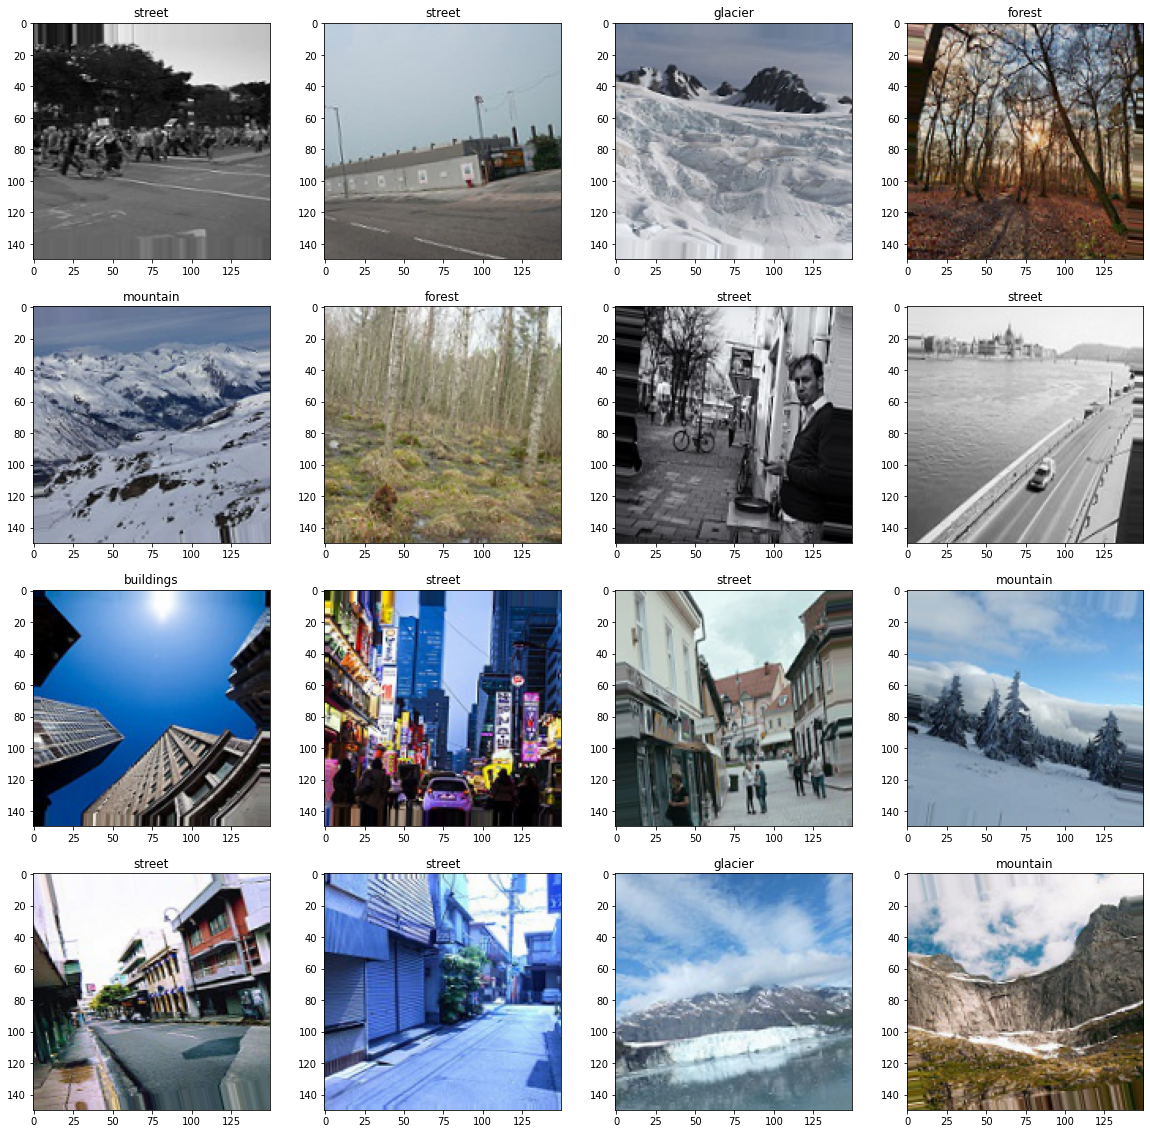

In [11]:
# training dataset 에서 샘플 데이터를 display 해본다
for X_batch, y_batch in train_datagen.flow_from_directory('/content/seg_train/seg_train',
                                                          batch_size=100, class_mode='sparse', target_size=(150, 150)):
    plt.figure(figsize=(20,20))
    # create a grid of 4x4 images
    for i in range(0, 16):
        ax = plt.subplot(4, 4, i+1)
        ax.set_title(findKey(train_generator.class_indices, y_batch[i]))   # 이미지의 label name 을 찾아온다 
        plt.imshow((X_batch[i].reshape(150, 150, 3)*255).astype(np.uint8)) # train 샘플 이미지를 보여준다.
    # show the plot
    plt.show()
    break

In [12]:
# create model(모델을 만듭니다)
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), name="conv1"))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name="conv2"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool1"))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name="conv3"))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name="conv4"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool2"))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name="conv5"))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name="conv6"))
model.add(MaxPooling2D(pool_size=(3, 3), name="maxpool3"))
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 146, 146, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 48, 48, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 46, 46, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 44, 44, 128)       147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv5 (Conv2D)               (None, 12, 12, 256)       2

In [13]:
# model training(모델을 학습시킵니다)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=140, 
                    epochs=40, 
                    validation_data=test_generator, 
                    validation_steps=30) 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
140/140 [==============================] - 124s 750ms/step - loss: 2.7100 - accuracy: 0.4576 - val_loss: 2.1800 - val_accuracy: 0.5567
Epoch 2/40
140/140 [==============================] - 104s 743ms/step - loss: 1.9720 - accuracy: 0.5891 - val_loss: 1.7676 - val_accuracy: 0.6427
Epoch 3/40
140/140 [==============================] - 104s 744ms/step - loss: 1.6417 - accuracy: 0.6615 - val_loss: 1.5238 - val_accuracy: 0.6807
Epoch 4/40
140/140 [==============================] - 104s 744ms/step - loss: 1.4429 - accuracy: 0.7059 - val_loss: 1.3704 - val_accuracy: 0.7277
Epoch 5/40
140/140 [==============================] - 104s 744ms/step - loss: 1.3302 - accuracy: 0.7249 - val_loss: 1.2466 - val_accuracy: 0.7503
Epoch 6/40
140/140 [==============================] - 104s 745ms/step - loss: 1.2127 - accuracy: 0.7567 - val_loss: 1.2059 - val_accuracy: 0.7467
Epoch 7/40
140/140 [==============================] - 104s 744ms/step - loss: 1.1585 - accuracy: 0.7607 - val_loss: 1.0940 -

In [14]:
# model evaluate(모델을 평가해 봅니다)
score = model.evaluate(test_generator, steps=30, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 0.4959777891635895
Test accuracy: 86.2333357334137


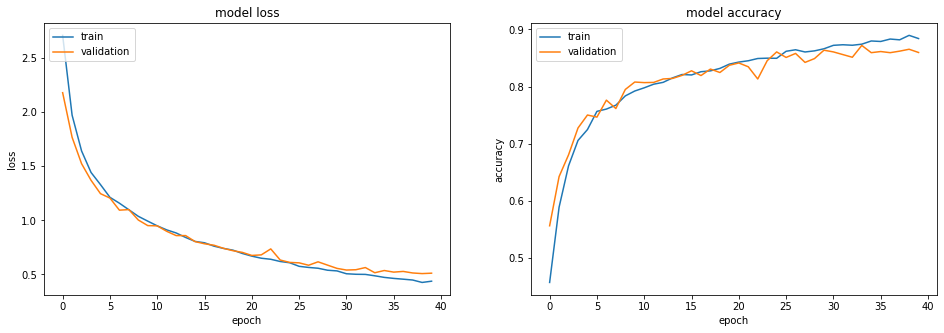

In [15]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [16]:
# 전체 모델을 H5 파일로 저장합니다
model.save('/content/gdrive/MyDrive/Intel_Image_Classification/Intel_image_classification_model.h5')
print("Saved model to disk")

Saved model to disk


In [17]:
# 디렉토리에서 이미지 파일들을 읽어오는 함수 정의
def get_images(directory):
    Images = []
    pred_img_cnt = 25  # 예측할 이미지를 몇개 불러 올 것인지 설정
    i = 0
    for image_file in os.listdir(directory):          # 디렉토리로부터 파일을 하나하나 불러 온다
        i += 1
        if i > pred_img_cnt: break
        else:
             image = cv2.imread(directory+r'/'+image_file) # 불러온 이미지를 openCV 로 읽어 들인다
             image = cv2.resize(image,(150,150))           # 이미지 크기 재조정
             Images.append(image)

    return Images

In [18]:
# 예측 할 이미지를 불러온다
pred_images = get_images('/content/seg_pred/seg_pred')
pred_images = np.array(pred_images) * 1./255
pred_images.shape

(25, 150, 150, 3)

In [19]:
# 예측할 이미지를 우리가 만든 모델을 통해 분류 예측해 봅니다.
prediction = model.predict(pred_images, verbose=1)

1/1 [==============================] - 1s 548ms/step


In [20]:
# test_generator 가 만들어 내는 이미지의 클래스 인덱스가 무엇인지 확인해 본다.

print(test_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


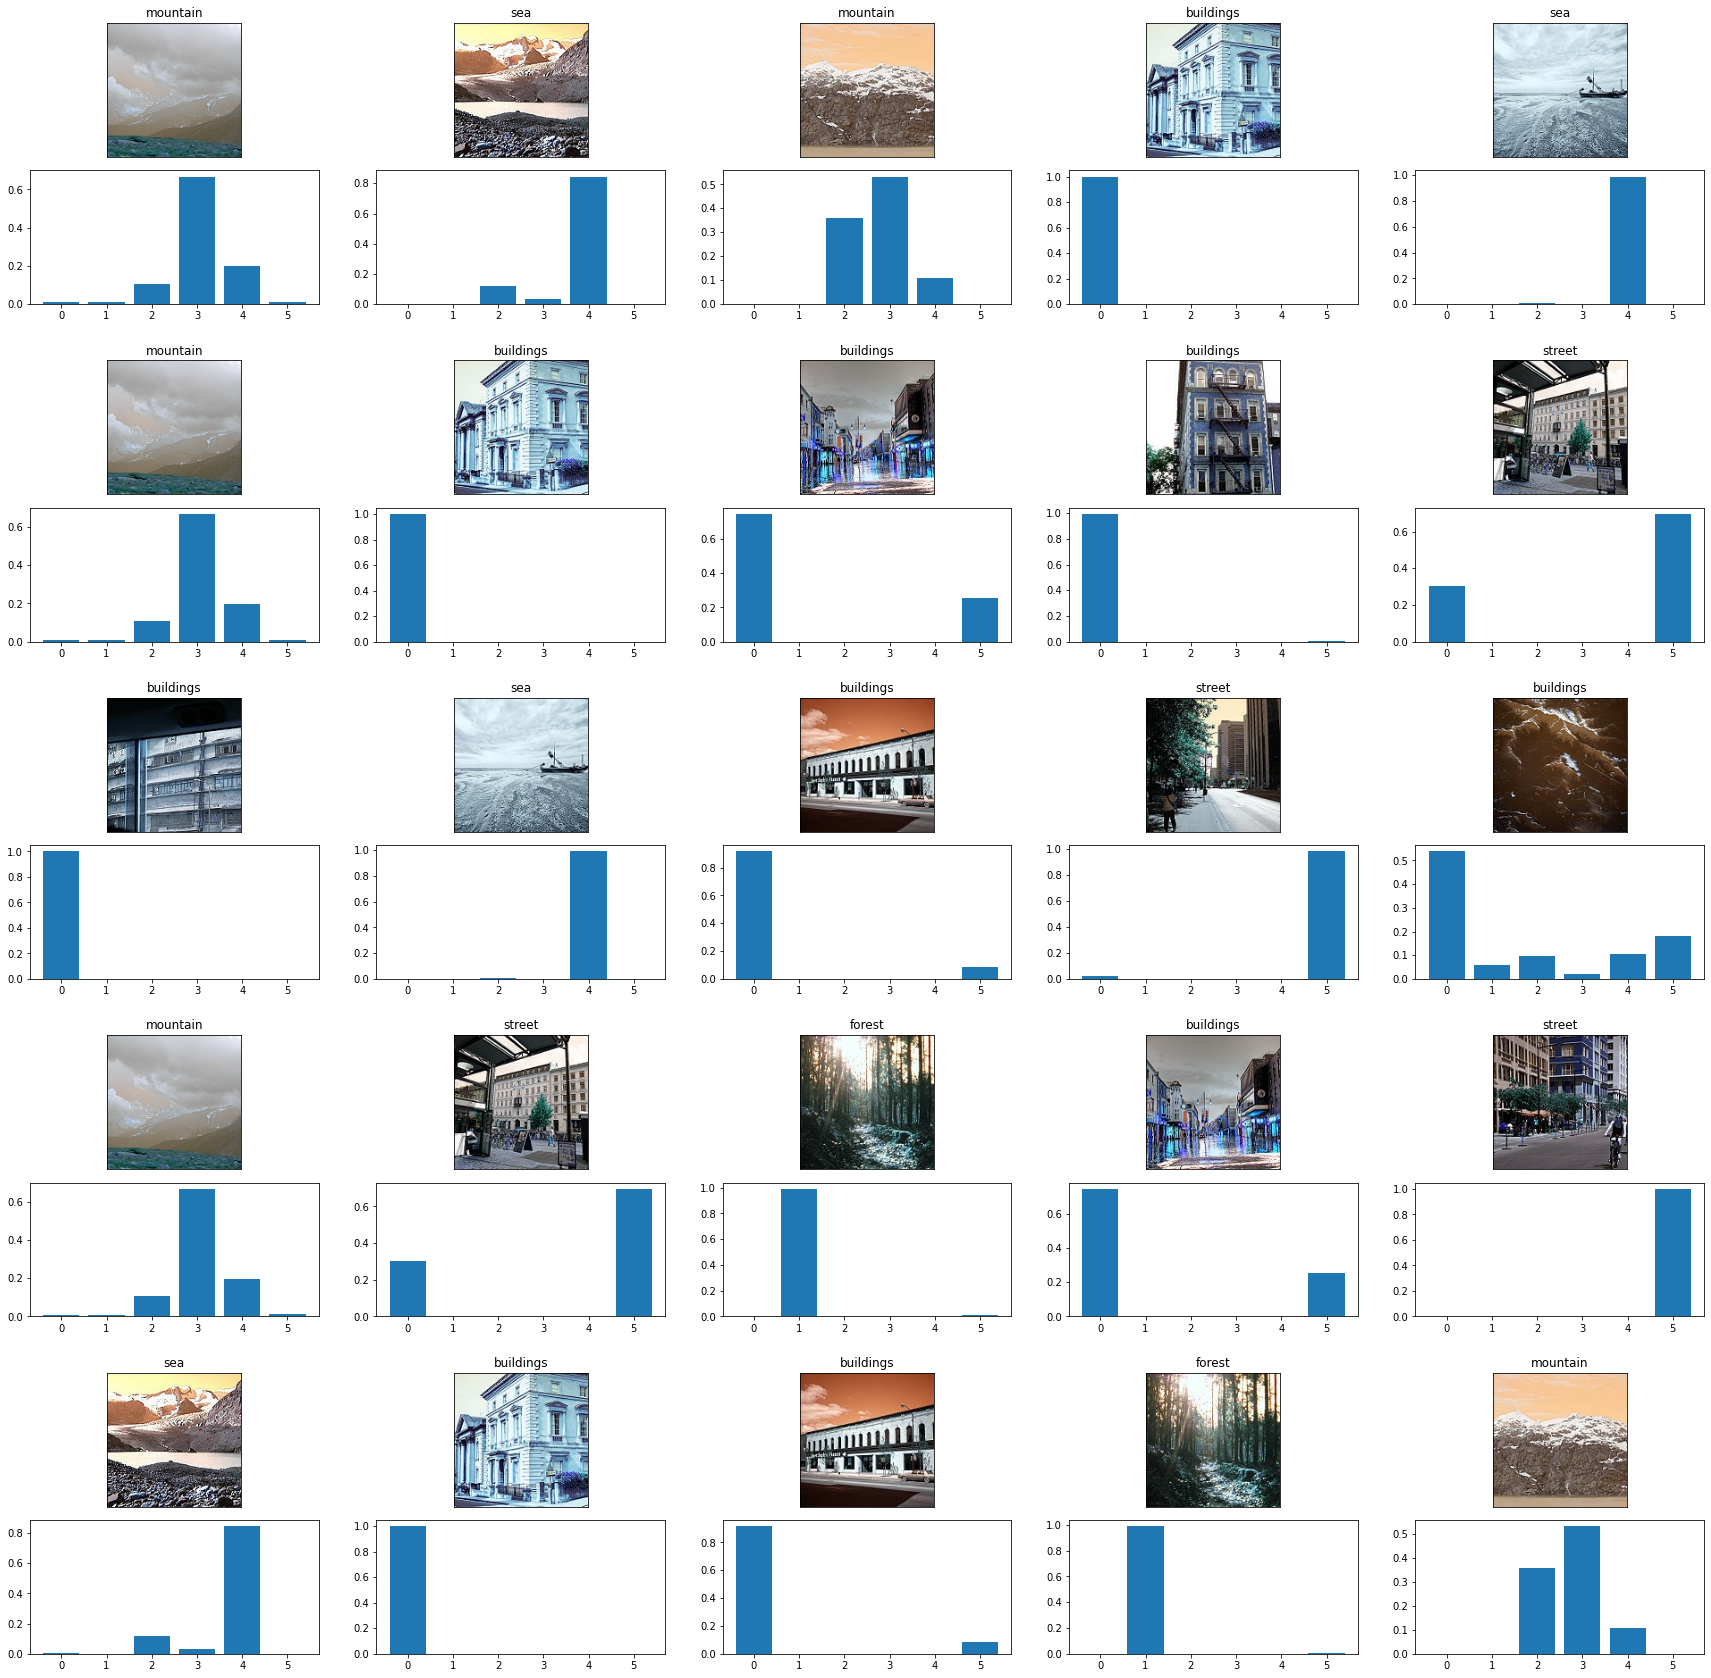

In [22]:
# 예측한 결과는 아래와 같습니다. 이미지의 위에는 class label을 이미지 아래에는 확률을 나타냅니다.

fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images)-1)
    pred_image = np.array([pred_images[rnd_number]])

    pred_class = findKey(train_generator.class_indices, np.argmax(prediction[rnd_number]))  # 이미지의 label name 을 찾아옵니다.
    pred_prob = prediction[rnd_number].reshape(6)   # 예측된 결과(확률값)를 1차원 배열(6칸)로 reshape 합니다. 
    for j in range(2):
        if (j%2) == 0:                        # 처음에는 이미지와 title(label name) 을 보여줍니다.
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:                                 # 그다음은 확률값을 그래프 형태로 보여줍니다. 
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

fig.show()